In [175]:
import chess
import chess.svg
# https://python-chess.readthedocs.io/en/latest/index.html

import time
from IPython.display import display, SVG
from IPython.core.display_functions import clear_output

In [176]:
def evaluate_board(board):
    outcome = board.outcome(claim_draw=True)
    if outcome:
        if outcome.winner == chess.WHITE:
            return 100000
        elif outcome.winner == chess.BLACK:
            return -100000
        else:
            return 0 # Draw

    piece_values = {
        chess.PAWN: 100,
        chess.KNIGHT: 300,
        chess.BISHOP: 300,
        chess.ROOK: 500,
        chess.QUEEN: 900
    }
    score = 0
    only_kings_and_pawns = True
    white_pawns = []
    black_pawns = []
    white_king = board.king(chess.WHITE)
    black_king = board.king(chess.BLACK)

    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            if piece.piece_type not in (chess.PAWN, chess.KING):
                only_kings_and_pawns = False
            value = piece_values.get(piece.piece_type, 0)
            if piece.color == chess.WHITE:
                score += value
                if piece.piece_type == chess.PAWN:
                    white_pawns.append(square)
            else:
                score -= value
                if piece.piece_type == chess.PAWN:
                    black_pawns.append(square)

    pieces_count = len(board.piece_map())
    # check if the board is in king-pawn-king scenario
    if only_kings_and_pawns and pieces_count >= 2:

        pawn_advance_scale = 50
        king_proximity_scale = 10

        # reward pawns closer to being promoted
        for square in white_pawns:
            rank = chess.square_rank(square)
            score += rank * pawn_advance_scale
        for square in black_pawns:
            rank = chess.square_rank(square)
            score -= (7 - rank) * pawn_advance_scale # closer to 0 is better for black

        # reward king being close to its pawns
        if white_pawns:
            distance = 0
            for square in white_pawns:
                distance += chess.square_distance(white_king, square)
            score -= (distance/len(white_pawns)) * king_proximity_scale # penalise king being further away from its pawns
        if black_pawns:
            distance = 0
            for square in black_pawns:
                distance += chess.square_distance(black_king, square)
            score += (distance / len(black_pawns)) * king_proximity_scale

        opposition_scale = 15
        defender_king_dist_scale = 5

        # when white has the pawn
        if len(white_pawns) == 1 and not black_pawns:
            pawn_square = white_pawns[0]
            promotion_square = chess.square(chess.square_file(pawn_square), 7)

            # get the distances of both kings to the promotion square
            # if white king is closer than black this is better, more control over the path to promotion
            dist_white_king_to_promotion = chess.square_distance(white_king, promotion_square)
            dist_black_king_to_promotion = chess.square_distance(black_king, promotion_square)
            score += (dist_black_king_to_promotion - dist_white_king_to_promotion)  * opposition_scale # add the difference to the score * scale

            # reward white if black king is further away from its pawn
            dist_black_king_to_pawn = chess.square_distance(black_king, pawn_square)
            score += dist_black_king_to_pawn * defender_king_dist_scale

        # When black has the pawn
        elif len(black_pawns) == 1 and not white_pawns:
            pawn_square = black_pawns[0]
            promotion_square = chess.square(chess.square_file(pawn_square), 0)

            dist_black_king_to_promotion = chess.square_distance(black_king, promotion_square)
            dist_white_king_to_promotion = chess.square_distance(white_king, promotion_square)
            score -= (dist_white_king_to_promotion - dist_black_king_to_promotion) * opposition_scale

            dist_white_king_to_pawn = chess.square_distance(white_king, pawn_square)
            score -= dist_white_king_to_pawn * defender_king_dist_scale

    return score

In [177]:
class SearchTreeNode:
    def __init__(self, board_instance, max_depth, ply=0):
        self.children = []
        self.value_is_assigned = False
        self.ply_depth = ply
        self.current_board = board_instance

        outcome = self.current_board.outcome(claim_draw=True)
        if outcome:
            self.value_is_assigned = True
            if outcome.winner == chess.WHITE:
                self.value = 100000
            elif outcome.winner == chess.BLACK:
                self.value = -100000
            else:
                self.value = 0 # Draw
        elif self.ply_depth >= max_depth:
            self.value = evaluate_board(self.current_board)
            self.value_is_assigned = True
        else:
            self.generate_children(max_depth)

    def generate_children(self, max_depth):
        # order the children to improve alpha-beta pruning. by having better moves checked first, subsequent children can be pruned sooner than if it were unordered.
        def order_moves(board):
            def get_move_priority(move):
                priority = 0
                piece = board.piece_at(move.from_square)
                if move.promotion:
                    priority += 100
                if board.is_capture(move):
                    priority += 50
                if piece.piece_type == chess.PAWN:
                    priority += 10
                if board.gives_check(move):
                    priority += 5
                return priority
            return sorted(board.legal_moves, key=get_move_priority, reverse=True)

        ordered_moves = order_moves(self.current_board)
        for move in ordered_moves:
            child_board = self.current_board.copy() # chess copy method
            child_board.push(move)
            child_node = SearchTreeNode(child_board, max_depth, ply=self.ply_depth + 1)
            self.children.append(child_node)

    def min_max_value(self, alpha=-float('inf'), beta=float('inf')):
        if self.value_is_assigned:
            return self.value

        # self.children.sort(key=lambda child: child.min_max_value())

        is_maximising = self.current_board.turn == chess.WHITE

        #if (self.ply_depth % 2) == 0: # player (maximising)
        if is_maximising:
            #self.value = self.children[-1].value
            bestVal = float('-inf')
            for child in self.children:
                value = child.min_max_value(alpha, beta)
                bestVal = max(bestVal, value)
                alpha = max(alpha, value)
                if beta <= alpha:
                    break  # Beta cut-off
            self.value = bestVal
        else: # opponent (minimising)
            #self.value = self.children[0].value
            bestVal = float('inf')
            for child in self.children:
                value = child.min_max_value(alpha, beta)
                bestVal = min(bestVal, value)
                beta = min(beta, value)
                if beta <= alpha:
                    break  # Alpha cut-off
            self.value = bestVal

        self.value_is_assigned = True
        return self.value

In [178]:
def play_chess_game(max_depth=2, board_scenario=chess.Board):
    response = input("Do you wish to play as white or black (w/b) ?")
    players_turn  = (response == "w")

    cb = board_scenario

    while True:
        if players_turn:
            board_svg = chess.svg.board(cb, size=300, orientation=cb.turn)
            display(SVG(board_svg))
            time.sleep(2) # give the board a second to display
            while True:
                try:
                    move_input = input("\nEnter your move (eg. e2e3, or e7e8q for promotion): ")
                    move = cb.parse_uci(move_input.lower().strip())
                    if move in cb.legal_moves:
                        cb.push(move)
                        break
                    else:
                        print("Invalid move")
                except Exception as e: print("Invalid move")

        else:
            print("AI is thinking 🤖...")
            search_tree = SearchTreeNode(cb, max_depth)
            search_tree.min_max_value()

            if cb.turn == chess.WHITE: # If AI is white, get maximising node
                best_child_node = max(search_tree.children, key=lambda child: child.value) # get the node that leads to the best scenario
            else: # if AI is black, get minimising node
                best_child_node = min(search_tree.children, key=lambda child: child.value)
            best_move = best_child_node.current_board.move_stack[-1] # get the move that leads to the best node (last move in the move stack)
            cb.push(best_move)
            print(f"AI made move: {best_move}, Move value: {best_child_node.value}")

        outcome = cb.outcome(claim_draw=True)
        if outcome:
            if outcome.winner is None:
                print("Draw! 🤝")
                board_svg = chess.svg.board(cb, size=300, orientation=cb.turn)
                display(SVG(board_svg))
            else:
                if players_turn:
                    if outcome.winner == chess.WHITE:
                        print("You win! 🥳")
                    else:
                        print("You lose! 😵")
                    board_svg = chess.svg.board(cb, size=300, orientation=not cb.turn)
                    display(SVG(board_svg))
                else:
                    if outcome.winner == chess.BLACK:
                        print("You win! 🥳")
                    else:
                        print("You lose! 😵")
                    board_svg = chess.svg.board(cb, size=300, orientation=not cb.turn)
                    display(SVG(board_svg))
            break
        players_turn = not players_turn

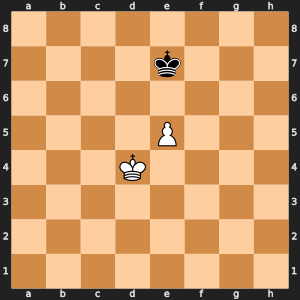

AI is thinking 🤖...
AI made move: e7d7, Move value: 305.0


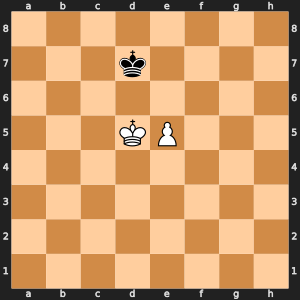

Invalid move
Invalid move
AI is thinking 🤖...
AI made move: d7e6, Move value: 260.0


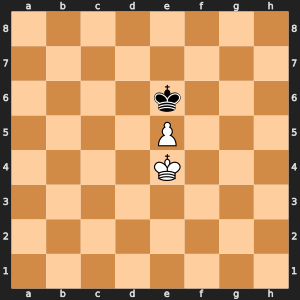

AI is thinking 🤖...
AI made move: e6f7, Move value: 305.0


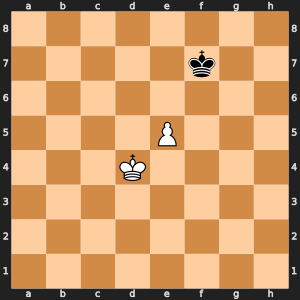

KeyboardInterrupt: Interrupted by user

In [180]:
board = chess.Board(fen="8/4k3/8/4P3/3K4/8/8/8 w - - 0 1")
play_chess_game(5, board)

Conclusion
- successfully implemented search tree capable of handling king-pawn-king scenario
- improvements: additional evaluations for scenarios of different stages game stages (opening, mid, endgame)

In [ ]:
board = chess.Board(fen="8/4k3/8/4P3/3K4/8/8/8 w - - 0 1")
play_chess_game(5, board)